# Problem 6: Multilayer Perceptron

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from utils.activations import softmax, sigmoid
from utils.data_parser import data_split_train_test
np.random.seed(1)

#define constants
num_class = 4 # no of classes
hidden_layer_units = 25  #number of units in the hidden layer
epochs = 200  #number of iterations
alpha = 0.001 #learning rate 


## DataSource
We split the provided data into 2 sets: training set and validation set with the ration 8:2

In [2]:
x = pd.read_csv(os.path.join('data','train_data.csv'), header=None).add_prefix('Feature_')
y = pd.read_csv(os.path.join('data', 'train_labels.csv'), header=None, names=["Label_0", "Label_1", "Label_2", "Label_3"])
X, Y, X_v, Y_v = data_split_train_test(x, y)
X_train = X.values   #training samples
Y_train = Y.values   #training labels

m, n = X_train.shape  #samples x features
X_Validate = X_v.values  #validation samples
Y_Validate = Y_v.values  #validation labels


## Layer, Forward Propagation, and Backward Propagation
We then implement Layer, Forward Propagation, and Back Propagation as follow
<img align="left" src="system.png"     style=" width:380px; padding: 10px; " >


In [3]:
def Layer(A_in, W, B, g):
    """
    :param A_in: shape(m,n) - input data
    :param W: shape(feature,units) - weight matrix, n0 feature  x units, 
    :param b: shape(units,1) - bias vector, n0 units x 1
    :param g: activation function(e.g sigmoid, relu, softmax, ...)
    :return:
    Z - linear regression
    A_out: shape(m, units): output data - m x units
    """
    Z = np.dot(A_in, W) + B
    A_out = g(Z)
    return Z,A_out

In [4]:
def compute_forward_prop(x, W1, b1, W2, b2):
    z1, a1 = Layer(x, W1, b1, sigmoid)  #hidden layer [1] with sigmoid activation
    z2, a2 = Layer(a1, W2, b2, softmax) #output layer [2] with softmax activation
    return z1, a1, z2, a2

Back-propagation is computed by the formulas:
$$dz^{[2]}=a^{[2]} - Ytrain$$
$$dW^{[2]}=\frac{1}{m}dz^{[2]}a^{[1]}$$
$$db^{[2]}=\frac{1}{m}\sum dz^{[2]T}$$
$$dz^{[1]}=W^{[2]T}dz^{[2]}*g'(z^{[1]})$$
$$dW^{[1]}=\frac{1}{m}dz^{[1]}X^{T}$$
$$db^{[1]}=\frac{1}{m}\sum dz^{[1]T}$$

In [5]:
def sigmoid_derivative(x): 
    return sigmoid(x) * (1 - sigmoid(x))

def compute_backward_prop(Z1, A1, A2, W2,X, Y): 
    dz2 = A2 - Y
    dW2 = np.dot(A1.T,dz2)
    db2 = dz2
    dz1 = np.dot(dz2,W2.T)
    db1 = dz1 * sigmoid_derivative(Z1)
    dW1 = np.dot(X.T,dz1 * sigmoid_derivative(Z1))
    return db1, dW1, db2, dW2

<p style="page-break-after:always;"></p>

## Gradient descent 
Then, these values from back-prop will be fed into gradient descent algorithm to re-calculate the weights and bias, so that the system can minimize the cost function:
$$W^{[1]} = W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} = b^{[1]} - \alpha db^{[1]}$$
$$W^{[2]} = W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} = b^{[2]} - \alpha db^{[2]}$$

In [6]:
def update_model_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha_):
    W1 = W1 - alpha_ * dW1
    W2 = W2 - alpha_ * dW2
    b1 = b1 - alpha_ * db1.sum(axis=0)
    b2 = b2 - alpha_ * db2.sum(axis=0)
    return b1, W1, b2, W2

## Cost function
Cost function is defined by the average of square of error function
$$Cost = \frac{1}{m}\sum_{i=0}^{m}(\hat{y}-y)^2$$

In [7]:
def compute_cost(y_hat, y):
    return np.mean(np.square(y_hat - y))

## Initialize model parameters
The model parameters are intialized randomly as follow:

In [8]:

def initialize_model_params():
    W1 = np.random.randn(n, hidden_layer_units)
    b1 = np.random.randn(hidden_layer_units)
    W2 = np.random.randn(hidden_layer_units, num_class)
    b2 = np.random.randn(num_class)
    return b1, W1, b2, W2

<p style="page-break-after:always;"></p>

## Accuracy and one-hot encode
In order to analyze the results, the implementation of prediction and accuracy are showed below:  

In [9]:
def predict(X, B1, W1, B2, W2):
    Z1 = np.dot(X, W1) + B1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + B2
    A2 = softmax(Z2)
    prediction = np.argmax(A2, 0)
    return prediction

def compute_accuracy(Y_hat, Y):
    correct_count = sum((Y[i] == Y_hat[i]).all() for i in range(len(Y)))
    accuracy = correct_count / len(Y)
    return accuracy

def convert_to_one_hot(A):
    num_classes = A.shape[1]
    max_value = np.max(A) + 1
    one_hot_encoded = np.zeros((A.shape[0], num_classes), dtype=int)
    indices = np.argmax(A, axis=1)
    one_hot_encoded[np.arange(A.shape[0]), indices] = 1
    return one_hot_encoded

## Training data
Sequence of the training process: Compute forward-propagation -> compute backward-propagation -> compute gradient descend, then repeat until convergence. 

In [21]:
def training_data(X, Y, X_v, Y_v, epochs, alpha):
    b1, W1, b2, W2 = initialize_model_params()
    accuracy = 0.
    epochs_plt = []
    costs_plt = []
    acc_plt = []
    for i in range(epochs):
        z1, a1, z2, a2 = compute_forward_prop(X, W1, b1, W2, b2)
        db1, dW1, db2, dW2 = compute_backward_prop(z1, a1, a2, W2, X, Y) 
        b1, W1, b2, W2 = update_model_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        #compute cost for each epoch        
        cost = compute_cost(a2, Y) 
        #avoid overfitting by using validation set for prediction
        _,_,_,y_hat = compute_forward_prop(X_v, W1, b1, W2, b2)
        #convert prediction to one-hot encode
        y_hat_encoded = convert_to_one_hot(y_hat)

        accuracy = compute_accuracy(y_hat_encoded, Y_v)
        if i % 10 == 0:
            print("Epoch: ", i)
            print(f"cost = {cost}  accuracy={accuracy * 100}")
            epochs_plt.append(i)
            costs_plt.append(cost)
            acc_plt.append(accuracy)
    plt.title('Cost vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.plot(epochs_plt,costs_plt,'r-')
    plt.show()

    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(epochs_plt,acc_plt,'g-')
    plt.show()
    return b1, W1, b2, W2, accuracy * 100

Run the training process with $epochs=200, \alpha=0.001$:

Epoch:  0
cost = 0.292323583256822  accuracy=30.741264391032114
Epoch:  10
cost = 0.13056237698384193  accuracy=66.00686729953544
Epoch:  20
cost = 0.12876165228028424  accuracy=72.32882246010907
Epoch:  30
cost = 0.08082811525150022  accuracy=84.91213896182589
Epoch:  40
cost = 0.023233152458728774  accuracy=94.04160775600889
Epoch:  50
cost = 0.021188888879907497  accuracy=94.68794182993334
Epoch:  60
cost = 0.01886165875201662  accuracy=95.25348414461725
Epoch:  70
cost = 0.017208083793544778  accuracy=95.41506766309837
Epoch:  80
cost = 0.016169312751626745  accuracy=95.61704706119976
Epoch:  90
cost = 0.015686547567048896  accuracy=95.71803676025046
Epoch:  100
cost = 0.014581158010177328  accuracy=95.87962027873157
Epoch:  110
cost = 0.014299794413790475  accuracy=95.83922439911129
Epoch:  120
cost = 0.013857943676070768  accuracy=96.06140173702282
Epoch:  130
cost = 0.013348540674962314  accuracy=96.1017976166431
Epoch:  140
cost = 0.013016775396985657  accuracy=96.1219955564532

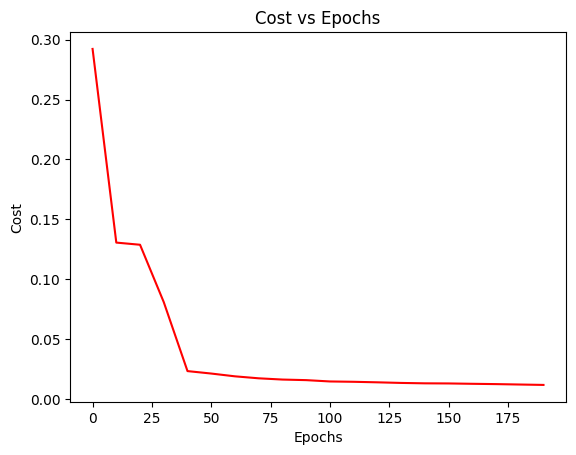

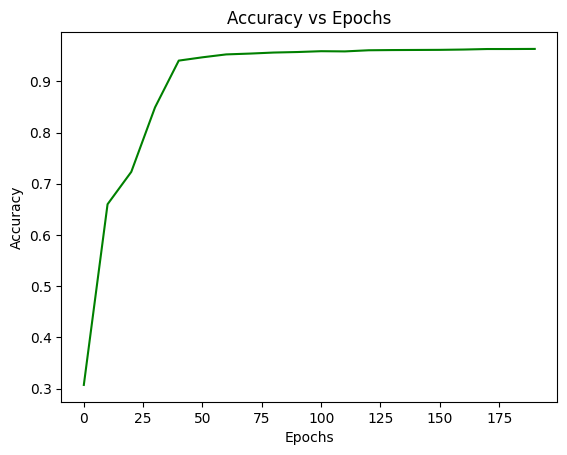

In [22]:
b1, W1, b2, W2, accuracy = training_data(X_train, Y_train, X_Validate, Y_Validate, epochs, alpha)

The accuracy of the validation set is around 95%

In [23]:
accuracy

96.4047667137952

And the model parameters are:

In [24]:
b1, W1, b2, W2

(array([-2.31249843, -3.59901166, -0.09179806, -1.32658126, -2.42168148,
        -1.26312159, -0.90127076, -0.44749647, -1.4711427 , -2.21092297,
        -1.45191723, -4.11878958,  0.21940422, -1.13715157,  0.18337743,
        -1.17931839, -1.77624103,  0.72674977, -2.66732253, -0.54202341,
        -0.69594156, -3.53252988, -2.48201306, -0.26447159, -2.87091948]),
 array([[ 0.90870638, -0.49267221, -0.8131967 , ..., -0.63363459,
          0.53467674,  0.26140941],
        [-1.03309464,  2.44498868,  1.45353074, ..., -0.29863559,
          2.09026825,  2.22233814],
        [-0.6802419 , -0.29612434,  1.68936478, ...,  1.16983421,
          1.95513128,  1.92115494],
        ...,
        [ 1.2844543 , -0.66156493,  1.48452139, ..., -0.05867049,
         -0.78037502, -0.93249573],
        [-1.08703666,  0.47242105,  0.2128596 , ...,  1.55220496,
          0.02407665, -0.40401796],
        [-0.12246359, -0.56665525,  2.20345081, ...,  0.35151711,
         -1.19301167, -1.06692523]]),
 array

Finally, we can save them for later prediction

In [25]:
np.save('hidden_weight.npy', W1)
np.save('hidden_bias.npy', b1)
np.save('output_weight.npy', W2)
np.save('output_bias.npy', b2)

# Conclusion

In [26]:
X_test = np.random.rand(1, n)
print(X_test.shape)
prediction = predict(X_test, b1, W1, b2, W2)
print(f"prediction = {prediction}")
print(f"X_test = {X_test}")

(1, 784)
prediction = [0 0 0 0]
X_test = [[4.47219462e-01 9.40933340e-01 4.12540244e-01 9.89852340e-02
  4.66001749e-02 8.31355759e-01 3.96245830e-01 4.01009295e-01
  9.03685669e-01 7.48073869e-02 3.75022432e-01 8.69790809e-01
  3.02556133e-01 5.41628612e-01 3.63241584e-01 9.20323192e-01
  2.69107133e-01 4.75690742e-02 7.74415578e-01 9.94724494e-03
  7.86351202e-01 2.58692025e-01 2.64400044e-01 2.82021514e-01
  9.09194958e-01 5.26459115e-01 2.87075011e-01 8.39075928e-01
  8.25320971e-01 8.47255759e-01 4.16027234e-01 1.51477743e-01
  3.51766985e-01 3.40547249e-01 8.99944453e-01 4.84141066e-01
  1.65810815e-01 7.79720449e-01 3.16149297e-01 3.56759302e-01
  5.49806002e-01 9.15839358e-01 5.15312386e-01 7.76989612e-01
  2.01624903e-01 7.89080285e-01 6.33826206e-01 9.29610683e-01
  4.34962824e-01 6.31843605e-01 9.29237057e-01 1.61313080e-03
  3.28541157e-01 9.22132363e-01 6.53387050e-01 8.63532621e-01
  2.66341276e-01 6.39916794e-01 3.31969868e-01 6.56164573e-01
  6.98268105e-01 5.70467379e-